## 首先我们使用pycharm爬去链家二手房的房价交易数据
    
    <h1> 爬起的scrapy框架的spider部分如下：<h1/>

In [ ]:
# -*- coding: utf-8 -*-
import scrapy
from lianjiawang.items import LianjiawangItem

class GetInfoSpider(scrapy.Spider):
    name = 'get_info'
    allowed_domains = ['gz.lianjia.com']
    start_urls = ['https://gz.lianjia.com/chengjiao/pg1/']
    n=2
    def parse(self, response):
        try:
            room_info = response.xpath('//ul[@class="listContent"]/li') # //ul[@class="listContent"]/li/a/@href
            # 遇到的问题,决解方案如下
            for urls in room_info:
                url = urls.xpath('./a/@href').extract_first()
                # print('66666',url)
                yield scrapy.Request(
                    url,
                    callback=self.parse_item,
                )
        except Exception as e:
            print(e)
            yield scrapy.Request(
                self.start_urls[0],
                callback=self.parse
            )

        next_page = 'https://gz.lianjia.com/chengjiao/pg{}/'.format(self.n)
        if self.n<=100:
            yield scrapy.Request(
                next_page,
                callback=self.parse,
            )
            self.n +=1

    def parse_item(self,response):
        item = LianjiawangItem()

        item['House_door_model'] = response.xpath('//div[@class="base"]/div[@class="content"]/ul/li[1]/text()').extract_first()
        item['architecture_acreage'] = response.xpath('//div[@class="base"]/div[@class="content"]/ul/li[3]/text()').extract_first()
        item['within_acreage'] = response.xpath('//div[@class="base"]/div[@class="content"]/ul/li[5]/text()').extract_first()
        item['Building_head'] = response.xpath('//div[@class="base"]/div[@class="content"]/ul/li[7]/text()').extract_first()
        item['decorate_situation'] = response.xpath('//div[@class="base"]/div[@class="content"]/ul/li[9]/text()').extract_first()
        item['heating_method'] = response.xpath('//div[@class="base"]/div[@class="content"]/ul/li[11]/text()').extract_first()
        item['period_int'] = response.xpath('//div[@class="base"]/div[@class="content"]/ul/li[13]/text()').extract_first()

        item['floor'] = response.xpath('//div[@class="base"]/div[@class="content"]/ul/li[2]/text()').extract_first()
        item['Family_structure'] = response.xpath('//div[@class="base"]/div[@class="content"]/ul/li[4]/text()').extract_first()
        item['building_types'] = response.xpath('//div[@class="base"]/div[@class="content"]/ul/li[6]/text()').extract_first()
        item['building_age'] = response.xpath('//div[@class="base"]/div[@class="content"]/ul/li[8]/text()').extract_first()
        item['building_structure'] = response.xpath('//div[@class="base"]/div[@class="content"]/ul/li[10]/text()').extract_first()
        item['Ladder_household_proportion'] = response.xpath('//div[@class="base"]/div[@class="content"]/ul/li[12]/text()').extract_first()
        item['Equipped_elevator'] = response.xpath('//div[@class="base"]/div[@class="content"]/ul/li[14]/text()').extract_first()

        # 交易属性
        item['house_id'] = response.xpath('//div[@class="transaction"]/div[@class="content"]/ul/li[1]/text()').extract_first()
        item['listing_time'] = response.xpath('//div[@class="transaction"]/div[@class="content"]/ul/li[3]/text()').extract_first()
        item['house_age'] = response.xpath('//div[@class="transaction"]/div[@class="content"]/ul/li[5]/text()').extract_first()
        item['Trading_ownership'] = response.xpath('//div[@class="transaction"]/div[@class="content"]/ul/li[2]/text()').extract_first()
        item['usage_house'] = response.xpath('//div[@class="transaction"]/div[@class="content"]/ul/li[4]/text()').extract_first()
        item['houseing_belog'] = response.xpath('//div[@class="transaction"]/div[@class="content"]/ul/li[6]/text()').extract_first()

        # 成交信息
        item['house_site'] = response.xpath('//div[@class="wrapper"]/text()').extract_first()
        item['bargain_time'] = response.xpath('//div[@class="wrapper"]/span/text()').extract_first()
        item['bargain_price'] = response.xpath('//div[@class="price"]/span/i/text()').extract_first()
        item['unit_price'] = response.xpath('//div[@class="price"]/b/text()').extract_first()
        item['listing_price'] = response.xpath('//div[@class="msg"]/span[1]/label/text()').extract_first()
        item['bargain_day_num'] = response.xpath('//div[@class="msg"]/span[2]/label/text()').extract_first()
        item['adjust_price'] = response.xpath('//div[@class="msg"]/span[3]/label/text()').extract_first()
        item['take_look'] = response.xpath('//div[@class="msg"]/span[4]/label/text()').extract_first()
        item['attention'] = response.xpath('//div[@class="msg"]/span[5]/label/text()').extract_first()
        item['view_count'] = response.xpath('//div[@class="msg"]/span[6]/label/text()').extract_first()

        # 成交人信息
        item['bargain_person_name'] = response.xpath('//div[@class="overview"]//div[@class="agent"]/div[@class="fr"]/a/b/text()').extract_first()
        item['user_score'] = response.xpath('//div[@class="overview"]//div[@class="agent"]/div[@class="fr"]/span/text()[1]').extract_first()
        item['user_num'] = response.xpath('//div[@class="overview"]//div[@class="agent"]/div[@class="fr"]/span/a/text()').extract_first()
        print(item)
        yield item

## 获取数据过后我们保持到mongodb的数据库里面。

     ### 下面我们对数据进行处理，
     ### 其实我们的主要目的就是对根据历史的成交房价的各种信息来预测未成交的房价。

#####  第一步读取MongoDB的数据进行保持

In [7]:
# 连接MongoDB

import pymongo
import pandas as pd

# 创建连接
client = pymongo.MongoClient('mongodb://localhost:27017/')
# 连接数据库
db = client['lianjia']

# 选择集合
room_price = db['fangyuanbigsz']

def read_mongodb_data():
    room_info = []
    for item in room_price.find():
        room_info.append(item)
    # 全部把这些数据转为pandas类型数据。
    room_data = pd.DataFrame(room_info,columns=list(room_info[0].keys()))
    return room_data

In [10]:
# coding:utf-8
import pandas as pd

# 获取数据
room_data = read_mongodb_data()
'''
['_id', 'House_door_model', 'architecture_acreage', 'within_acreage',
       'Building_head', 'decorate_situation', 'heating_method', 'period_int',
       'floor', 'Family_structure', 'building_types', 'building_age',
       'building_structure', 'Ladder_household_proportion',
       'Equipped_elevator', 'house_id', 'listing_time', 'house_age',
       'Trading_ownership', 'usage_house', 'houseing_belog', 'house_site',
       'bargain_time', 'bargain_price', 'unit_price', 'listing_price',
       'bargain_day_num', 'adjust_price', 'take_look', 'attention',
       'view_count', ]
'''
columns = room_data.columns
# print(columns)
data = room_data.iloc[:,1:-3].copy()
# 开始对数据进行处理。

data.head()
# data.to_csv('./data/data.csv')

,House_door_model,architecture_acreage,within_acreage,Building_head,decorate_situation,heating_method,period_int,floor,Family_structure,building_types,...,house_site,bargain_time,bargain_price,unit_price,listing_price,bargain_day_num,adjust_price,take_look,attention,view_count
0,2室1厅1厨1卫,63㎡,暂无数据,东南,简装,,70年,中楼层(共9层),暂无数据,塔楼,...,天鹅花苑 2室1厅 63平米,2018.10.26 成交,195,30953,210,39,0,0,0,暂无数据
1,3室2厅1厨2卫,100.34㎡,89㎡,南,简装,,70年,中楼层(共9层),暂无数据,塔楼,...,大沙头路11号大院 3室2厅 100.34平米,2018.10.27 成交,360,35879,400,34,0,0,0,143
2,2室1厅1厨1卫,39㎡,暂无数据,北,精装,,70年,高楼层(共23层),平层,塔楼,...,东方都会广场 2室1厅 39平米,2018.10.28 成交,250,64103,265,504,1,0,47,1908
3,3室2厅1厨1卫,83㎡,暂无数据,南,其他,,70年,高楼层(共7层),暂无数据,塔楼,...,万丰路 3室2厅 83平米,2018.10.27 成交,163,19639,168,28,0,0,0,暂无数据
4,3室2厅1厨2卫,124.5㎡,103.4㎡,南,简装,,70年,低楼层(共16层),暂无数据,塔楼,...,东方花园又一居 3室2厅 124.5平米,2018.10.27 成交,365,29318,375,43,1,0,6,879


<h3>开始对数据处理，其实数据处理方面是很费时间的，首先我们删除上面数据的最后面成交人的信息获取不到<h3/>
<ul>
  <li>清洗掉那些从网页上面爬取没有处理的空格字符串<li/>
<ul/>

In [11]:
# coding:utf-8
import pandas as pd
import numpy as np

data = pd.read_csv('./data/data.csv',sep=',',header=0,index_col=0)
'''
['_id', 'House_door_model', 'architecture_acreage', 'within_acreage',
       'Building_head', 'decorate_situation', 'heating_method', 'period_int',
       'floor', 'Family_structure', 'building_types', 'building_age',
       'building_structure', 'Ladder_household_proportion',
       'Equipped_elevator', 'house_id', 'listing_time', 'house_age',
       'Trading_ownership', 'usage_house', 'houseing_belog', 'house_site',
       'bargain_time', 'bargain_price', 'unit_price', 'listing_price',
       'bargain_day_num', 'adjust_price', 'take_look', 'attention',
       'view_count', ]
'''

# 清除空格数据

idx,columns = data.shape
room_info = pd.DataFrame(data=np.zeros((idx,columns)),columns=list(data.columns))
print(room_info.shape,data.shape)
for i in range(idx):
    for j in range(columns):

        room_info.iloc[i,j] = str(data.iloc[i,j]).strip()

# room_info.to_csv('./data/room_data.csv')



(1755, 30) (1755, 30)


### 对各种数据进行分割、提取、补全等等。

In [12]:
# coding:utf-8
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

data = pd.read_csv('./data/room_data.csv',sep=',',header=0,index_col=0)
# data = data1.copy()
'''
['_id', 'House_door_model', 'architecture_acreage', 'within_acreage',
       'Building_head', 'decorate_situation', 'heating_method', 'period_int',
       'floor', 'Family_structure', 'building_types', 'building_age',
       'building_structure', 'Ladder_household_proportion',
       'Equipped_elevator', 'house_id', 'listing_time', 'house_age',
       'Trading_ownership', 'usage_house', 'houseing_belog', 'house_site',
       'bargain_time', 'bargain_price', 'unit_price', 'listing_price',
       'bargain_day_num', 'adjust_price', 'take_look', 'attention',
       'view_count', ]
'''



# 插入某列 数据
# data.insert(0,'shi',[i for i in range(len(data.iloc[:,2]))])
# print(data.head())

# 1、对 House_door_model ：房户结构进行分解  2室1厅1厨1卫

def house_model(info):
    n = len(info)
    house_door_model = np.zeros((n,4))
    data = info.copy()
    for i,item in enumerate(data):
        if re.findall('\d',item).__len__():
            house_door_model[i,0],house_door_model[i,1],house_door_model[i,2], \
            house_door_model[i, 3]= [int(i) for i in re.findall('\d',item)]
        else:
            # 没有数据的全部给它一个室一卫
            house_door_model[i, 0], house_door_model[i, 1], house_door_model[i, 2], \
            house_door_model[i, 3] = [1,0,0,0]


    return house_door_model

# 把数据插入data。
info = data['House_door_model'].copy()
house_door_model = house_model(info)
house_list = ['house_室','house_厅','house_厨','house_卫']
for i,item in enumerate(house_list):
    data.insert(i,item,house_door_model[:,i])

# 删除掉house_door_model列
data.drop('House_door_model', axis=1, inplace=True)
# plt.scatter(range(len(house_door_model[:,2])),house_door_model[:,3])
# plt.show()



# 2、对 architecture_acreage 房子面积进行提取

architecture_acreage = data['architecture_acreage'].copy()

data.insert(4,'architecture_acreage_',[float(i) for i in [item.split('㎡')[0] for item in architecture_acreage]])

data.drop('architecture_acreage',axis=1,inplace=True)



# 3、对 within_acreage ：内部面积

within_acreage = data['within_acreage'].copy()
index_list = [i for i,item in enumerate(list(data.columns)) if item=='within_acreage'][0]

def rinse_within_acreage(info):
    df = info.copy()
    within_acreage_list = np.zeros((len(df),1))
    for i,item in enumerate(df):
        if str(item) == '暂无数据':
            within_acreage_list[i] = data['architecture_acreage_'][i]
        else:
            within_acreage_list[i] = float(item.split('㎡')[0])
    return within_acreage_list

data.insert(index_list,'within_acreage_',rinse_within_acreage(within_acreage)[:,0])

data.drop('within_acreage',axis=1,inplace=True)

#  清除空字段
data.drop('heating_method',axis=1,inplace=True)



# 字段 floor 楼层的高低 清洗

index_floor = [i for i,item in enumerate(list(data.columns)) if item=='floor'][0]

room_floor = data['floor'].copy()

def rinalyze_floor(df):
    df = df.copy()
    floor_list = np.zeros((len(df)))
    f_l = []
    for i,item in enumerate(df):
        floor_info = re.findall('(.*?)\(共(\d)层',item)
        if len(floor_info):
            # print(floor_info)
            f_l.append(floor_info[0][0])
            floor_list[i] = int(floor_info[0][1])
        else:
            f_l.append('底楼层')
            floor_list[i] = 1



    return [f_l,floor_list]

floor_ = rinalyze_floor(room_floor)

fl = ['floor_楼','floor_层']
for i,item in enumerate(fl):
    data.insert(i+index_floor,item,floor_[i])

data.drop('floor',axis=1,inplace=True)



# 处理 building_age 建筑时间

building_age = data['building_age'].copy()
build_index = [i for i,item in enumerate(list(data.columns)) if item=='building_age'][0]

def rinalyze_building_age(df):
    df = df.copy()
    build = np.zeros((len(df)),dtype='int')
    for i,item in enumerate(df):
        if str(item) == '未知':
            build[i] = 2000
        else:
            build[i] = int(item)
    return build

data.insert(build_index,'building_age_',rinalyze_building_age(building_age))

data.drop('building_age',axis=1,inplace=True)



# 删除链接编号
data.drop('house_id',axis=1,inplace=True)
data.drop('house_site',axis=1,inplace=True)
data.drop('listing_time',axis=1,inplace=True)
data.drop('bargain_time',axis=1,inplace=True)



# 清洗view_count

view_count = data['view_count'].copy()

def rinalyze_view_count(df,str_s):
    df = df.copy()
    view_data = []
    for item in df:
        if str(item)==str_s:
            pass
            # print('暂无数据')
        else:
            view_data.append(int(item))
    mean = np.floor(np.mean(np.array(view_data)))
    count = []
    for di in df:
        if str(di) == str_s:
            count.append(mean)
        else:
            count.append(int(di))

    return count

view_count_index = [i for i,item in enumerate(list(data.columns)) if item=='view_count'][0]

data.insert(view_count_index,'view_count_',rinalyze_view_count(view_count,str_s='暂无数据'))

data.drop('view_count',axis=1,inplace=True)

# print(data.iloc[0:5,-1])
# bargain_day_num

view_count_index = [i for i,item in enumerate(list(data.columns)) if item=='bargain_day_num'][0]

data.insert(view_count_index,'bargain_day_num_',rinalyze_view_count(view_count,str_s='暂无数据'))

data.drop('bargain_day_num',axis=1,inplace=True)


print(data.shape)


data1 = data.copy()
# data1.to_csv('./data/room_data_2.csv',encoding='gbk')


(1755, 29)


### 下面我们选择合适的模型进行预测

<ul>
  <li>岭回归模型<li/>
   <li>随机森林回归<li/>
<ul/>

In [16]:
# coding:utf-8
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False
'''
model = pd.read_table('./data/模板字符.txt',sep='，',header=None,index_col=None,encoding='gbk',engine='python')
print(model)
str_model = list(model.values[0])
print(str_model)
'''

data = pd.read_csv('./data/room_data_2.csv',sep=',',header=0,index_col=0,encoding='gbk')

data.drop('Ladder_household_proportion',axis=1,inplace=True)

# 归一化数据 ：architecture_acreage_  within_acreage_  building_age_   unit_price
#   listing_price   bargain_day_num_   view_count_
# y_train    bargain_price


#  数据归一化处理，使用岭回归进行预测。

rinalyze_list = ['architecture_acreage_','within_acreage_','building_age_','unit_price',
                 'listing_price','bargain_day_num_','attention','view_count_']

y_train_ = data.pop('bargain_price')

x = [1,2,3,4,5,6,0]

def min_max_scaler(df):
    df = np.array(df)
    min_max = preprocessing.MaxAbsScaler()
    return min_max.fit_transform(df.reshape((-1,1))).reshape((-1))

for item in rinalyze_list:
    data[item] = min_max_scaler(data[item].copy())

y_train_data = min_max_scaler(y_train_.copy())

linsting_price = data['listing_price'].copy()[1500:]

# onehot编码处理
room_data = pd.get_dummies(data)
# room_data.to_csv('./data/train.csv',encoding='gbk')
# 分割训练数据和测试数据。
x_train = room_data.iloc[:1500,:]
y_train = y_train_data[:1500]
x_test = room_data.iloc[1500:,:]
y_test = y_train_data[1500:]

print(room_data.shape)
room_data.head()


(1755, 79)


,house_室,house_厅,house_厨,house_卫,architecture_acreage_,within_acreage_,floor_层,building_age_,unit_price,listing_price,...,house_age_满五年,Trading_ownership_商品房,Trading_ownership_房改房,usage_house_别墅,usage_house_商住两用,usage_house_普通住宅,usage_house_车库,houseing_belog_共有,houseing_belog_暂无数据,houseing_belog_非共有
0,2.0,1.0,1.0,1.0,0.218204,0.218204,9.0,0.993059,0.330730,0.155556,...,0,1,0,0,0,1,0,0,0,1
1,3.0,2.0,1.0,2.0,0.347534,0.308257,9.0,0.987605,0.383364,0.296296,...,0,1,0,0,0,1,0,0,0,1
2,2.0,1.0,1.0,1.0,0.135079,0.135079,1.0,0.993555,0.684934,0.196296,...,0,1,0,0,0,1,0,0,0,1
3,3.0,2.0,1.0,1.0,0.287476,0.287476,7.0,0.991572,0.209841,0.124444,...,0,1,0,0,0,1,0,0,1,0
4,3.0,2.0,1.0,2.0,0.431214,0.358132,1.0,0.992563,0.313260,0.277778,...,1,1,0,0,0,1,0,1,0,0


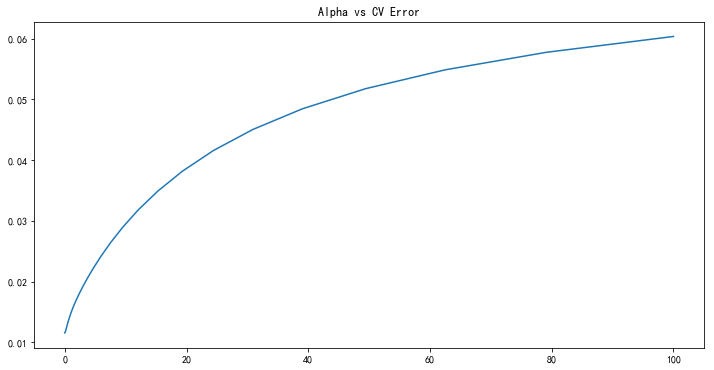

In [17]:
# plt.scatter(range(len(y_train)),y_train)

# 使用xgboost来选择模型超参


# 岭回归

plt.figure(figsize=(12,6))
alphas = np.logspace(-3, 2, 50)
test_scores = []
for alpha in alphas:
    clf = Ridge(alpha)
    test_score = np.sqrt(-cross_val_score(clf, x_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))


plt.plot(alphas, test_scores)
plt.title("Alpha vs CV Error")
plt.show()



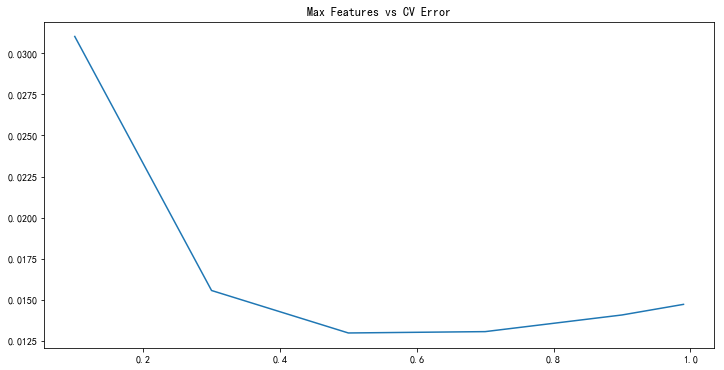

In [18]:
# 随机森林。

max_features = [.1, .3, .5, .7, .9, .99]
test_scores = []
for max_feat in max_features:
    clf = RandomForestRegressor(n_estimators=200, max_features=max_feat)
    test_score = np.sqrt(-cross_val_score(clf, x_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))
plt.figure(figsize=(12,6))
plt.plot(max_features, test_scores)
plt.title("Max Features vs CV Error")

plt.show()

#### 由岭回归的交叉验证和随机森林回归的交叉验证中我们可以看出：随机森林模型的max_features = 0.5的时候达到最优。

##### 所以我们选择了随机森林，结果如下

0.004459100366731717


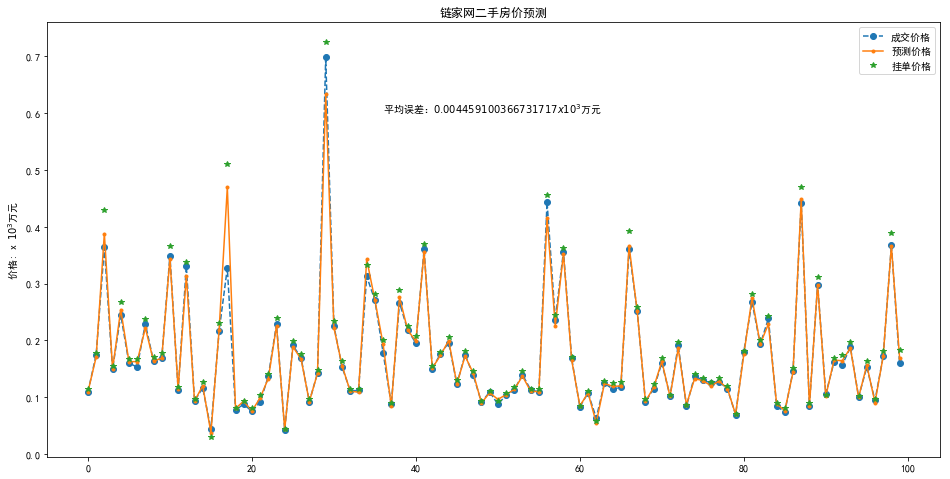

In [21]:
# 在选择超参数的使用随机森林表现更加优秀。大概max = 0.5左右

rf_model = RandomForestRegressor(n_estimators=200, max_features=0.5)
rf_model.fit(x_train,y_train)
y_pred = rf_model.predict(x_test)

# score = np.sum(np.abs(np.array(y_test)-np.array(y_pred)))/len(x_test)
# print(score)
from sklearn.metrics import mean_absolute_error
score = mean_absolute_error(np.array(y_test),np.array(y_pred))
print(score)

plt.figure(figsize=(16,8))
plt.plot(y_test[:100],'o--',label='成交价格')
plt.plot(y_pred[:100],'.-',label='预测价格')
plt.plot(range(len(linsting_price[:100])),linsting_price[:100],'*',label='挂单价格')
plt.ylabel('价格: x $10^3$万元')
plt.title('链家网二手房价预测')
plt.legend(loc='upper right')
plt.text(36,0.6,'平均误差：$%s x 10^3$万元'%score)
plt.show()